In [2]:
from fashion_mnist_master.fashion_mnist_master.utils import mnist_reader
import numpy as np

X_train, y_train = mnist_reader.load_mnist("fashion_mnist_master/fashion_mnist_master/data/fashion", kind='train')
X_test, y_test = mnist_reader.load_mnist("fashion_mnist_master/fashion_mnist_master/data/fashion", kind='t10k')

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================
# 0) Data preparation helpers
# ==============================
def prepare_data(X_train, X_test, val_fraction=0.1, normalize=True, seed=123, verbose=True):
    """
    تقسیم داده‌ها به Train/Validation، نرمال‌سازی و تبدیل به شکل (features, samples).
    """
    rng = np.random.RandomState(seed)
    N = X_train.shape[0]
    indices = rng.permutation(N)
    n_val = int(N * val_fraction)
    val_idx = indices[:n_val]
    train_idx = indices[n_val:]
    
    X_tr = X_train[train_idx].astype(np.float32)
    X_val = X_train[val_idx].astype(np.float32)
    X_te = X_test.astype(np.float32)
    
    if normalize:
        X_tr /= 255.0
        X_val /= 255.0
        X_te /= 255.0
    
    if verbose:
        print(f"Data prepared: Train={X_tr.shape[0]}, Val={X_val.shape[0]}, Test={X_te.shape[0]}")
    
    return X_tr.T, X_val.T, X_te.T  # shape: (features, samples)

# ==============================
# 1) Initialization
# ==============================
def initialize_weights(input_dim, hidden_dim, scale=0.01, seed=None, verbose=True):
    rng = np.random.RandomState(seed)
    W1 = rng.randn(hidden_dim, input_dim) * scale
    b1 = np.zeros((hidden_dim, 1), dtype=np.float32)
    W2 = rng.randn(input_dim, hidden_dim) * scale
    b2 = np.zeros((input_dim, 1), dtype=np.float32)
    if verbose:
        print(f"Weights initialized: W1({W1.shape}), b1({b1.shape}), W2({W2.shape}), b2({b2.shape})")
    return W1, b1, W2, b2

# ==============================
# 2) Activations
# ==============================
def sigmoid(z):
    """Sigmoid activation function."""
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_derivative_from_activation(s):
    """Derivative of sigmoid given activation value s."""
    return s * (1.0 - s)

# ==============================
# 3) Forward pass
# ==============================
def forward_pass(X_batch, W1, b1, W2, b2, verbose=False):
    z1 = W1 @ X_batch + b1
    h = sigmoid(z1)
    z2 = W2 @ h + b2
    y_hat = sigmoid(z2)
    if verbose:
        print(f"Forward pass: batch_size={X_batch.shape[1]}, hidden_dim={h.shape[0]}")
    cache = (X_batch, z1, h, z2, y_hat)
    return y_hat, cache

# ==============================
# 4) Loss
# ==============================
def mse_loss(X, Y):
    diff = X - Y
    return np.mean(diff * diff)

def psnr_from_mse(mse, data_max=1.0):
    if mse <= 0:
        return 100.0
    return 10.0 * np.log10((data_max ** 2) / mse)

# ==============================
# 5) Backprop
# ==============================
def backward_pass(cache, W2, verbose=False):
    X, z1, h, z2, y_hat = cache
    input_dim, batch_size = X.shape
    denom = input_dim * batch_size
    dL_dy = 2.0 * (y_hat - X) / denom
    dsig_z2 = sigmoid_derivative_from_activation(y_hat)
    dL_dz2 = dL_dy * dsig_z2

    dW2 = dL_dz2 @ h.T
    db2 = np.sum(dL_dz2, axis=1, keepdims=True)

    dL_dh = W2.T @ dL_dz2
    dsig_z1 = sigmoid_derivative_from_activation(h)
    dL_dz1 = dL_dh * dsig_z1

    dW1 = dL_dz1 @ X.T
    db1 = np.sum(dL_dz1, axis=1, keepdims=True)

    if verbose:
        print(f"Backprop: dW1={dW1.shape}, db1={db1.shape}, dW2={dW2.shape}, db2={db2.shape}")
    return dW1, db1, dW2, db2

# ==============================
# 6) Update
# ==============================
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, lr, verbose=False):
    W1 -= lr * dW1
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2
    if verbose:
        print("Parameters updated.")
    return W1, b1, W2, b2

# ==============================
# 7) Train one epoch
# ==============================
def train_epoch(X, W1, b1, W2, b2, lr, batch_size=32, verbose=False):
    n_samples = X.shape[1]
    perm = np.random.permutation(n_samples)
    total_loss = 0.0
    count = 0

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch_idx = perm[start:end]
        X_batch = X[:, batch_idx]
        y_hat, cache = forward_pass(X_batch, W1, b1, W2, b2, verbose=verbose)
        loss = mse_loss(X_batch, y_hat)
        dW1, db1, dW2, db2 = backward_pass(cache, W2, verbose=verbose)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, lr, verbose=verbose)
        total_loss += loss * (end - start)
        count += (end - start)

    avg_loss = total_loss / count
    return avg_loss, W1, b1, W2, b2

# ==============================
# 8) Full training
# ==============================
def train_autoencoder(X_train, X_val, input_dim, hidden_dim,
                      epochs=50, lr=0.01, batch_size=32, seed=None, verbose=True):
    W1, b1, W2, b2 = initialize_weights(input_dim, hidden_dim, seed=seed, verbose=verbose)
    history = {'train_loss': [], 'val_loss': [], 'val_psnr': []}

    for ep in range(1, epochs+1):
        train_loss, W1, b1, W2, b2 = train_epoch(X_train, W1, b1, W2, b2, lr, batch_size, verbose=False)
        y_val_hat, _ = forward_pass(X_val, W1, b1, W2, b2, verbose=False)
        val_loss = mse_loss(X_val, y_val_hat)
        val_psnr = psnr_from_mse(val_loss)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_psnr'].append(val_psnr)

        if verbose:
            print(f"[Epoch {ep}/{epochs}] Train MSE={train_loss:.6f}, Val MSE={val_loss:.6f}, Val PSNR={val_psnr:.2f} dB")

    return (W1, b1, W2, b2), history

# ==============================
# 9) Visualization
# ==============================
def reconstruct_samples(X, W1, b1, W2, b2, indices=None, n_show=5):
    if indices is None:
        indices = list(range(n_show))
    originals, reconstructions = [], []
    for idx in indices[:n_show]:
        x = X[:, idx:idx+1]
        y_hat, _ = forward_pass(x, W1, b1, W2, b2)
        originals.append((x.reshape(28,28)*255).astype(np.uint8))
        reconstructions.append((y_hat.reshape(28,28)*255).clip(0,255).astype(np.uint8))
    return originals, reconstructions

def show_image_pairs(originals, reconstructions, titles=None):
    n = len(originals)
    plt.figure(figsize=(6, 2*n))
    for i in range(n):
        plt.subplot(n,2,2*i+1)
        plt.imshow(originals[i], cmap='gray')
        plt.title("Original")
        plt.axis('off')
        plt.subplot(n,2,2*i+2)
        plt.imshow(reconstructions[i], cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# ==============================
# 10) Example run
# ==============================
def run_example(X_train_raw, X_test_raw, hidden_dim=64, epochs=30, lr=0.01, batch_size=64):
    X_tr, X_val, X_te = prepare_data(X_train_raw, X_test_raw, val_fraction=0.1, normalize=True, verbose=True)
    input_dim = X_tr.shape[0]
    (W1,b1,W2,b2), history = train_autoencoder(X_tr, X_val, input_dim, hidden_dim,
                                              epochs=epochs, lr=lr, batch_size=batch_size, seed=42, verbose=True)
    
    # plot losses
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='train MSE')
    plt.plot(history['val_loss'], label='val MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history['val_psnr'], label='val PSNR')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR (dB)')
    plt.legend()
    plt.show()

    # show reconstructions
    origs, recs = reconstruct_samples(X_val, W1, b1, W2, b2, indices=list(range(5)), n_show=5)
    show_image_pairs(origs, recs)

    # compute final test PSNR
    y_te_hat, _ = forward_pass(X_te, W1, b1, W2, b2)
    test_mse = mse_loss(X_te, y_te_hat)
    test_psnr = psnr_from_mse(test_mse)
    print("Final Test MSE:", test_mse, "Test PSNR (dB):", test_psnr)

    return (W1,b1,W2,b2), history


Data prepared: Train=54000, Val=6000, Test=10000
Weights initialized: W1((64, 784)), b1((64, 1)), W2((784, 64)), b2((784, 1))
[Epoch 1/100] Train MSE=0.168277, Val MSE=0.166037, Val PSNR=7.80 dB
[Epoch 2/100] Train MSE=0.164555, Val MSE=0.162339, Val PSNR=7.90 dB
[Epoch 3/100] Train MSE=0.160825, Val MSE=0.158589, Val PSNR=8.00 dB
[Epoch 4/100] Train MSE=0.157008, Val MSE=0.154725, Val PSNR=8.10 dB
[Epoch 5/100] Train MSE=0.153057, Val MSE=0.150719, Val PSNR=8.22 dB
[Epoch 6/100] Train MSE=0.148963, Val MSE=0.146581, Val PSNR=8.34 dB
[Epoch 7/100] Train MSE=0.144753, Val MSE=0.142355, Val PSNR=8.47 dB
[Epoch 8/100] Train MSE=0.140490, Val MSE=0.138117, Val PSNR=8.60 dB
[Epoch 9/100] Train MSE=0.136258, Val MSE=0.133958, Val PSNR=8.73 dB
[Epoch 10/100] Train MSE=0.132147, Val MSE=0.129961, Val PSNR=8.86 dB
[Epoch 11/100] Train MSE=0.128236, Val MSE=0.126198, Val PSNR=8.99 dB
[Epoch 12/100] Train MSE=0.124584, Val MSE=0.122714, Val PSNR=9.11 dB
[Epoch 13/100] Train MSE=0.121225, Val MSE=

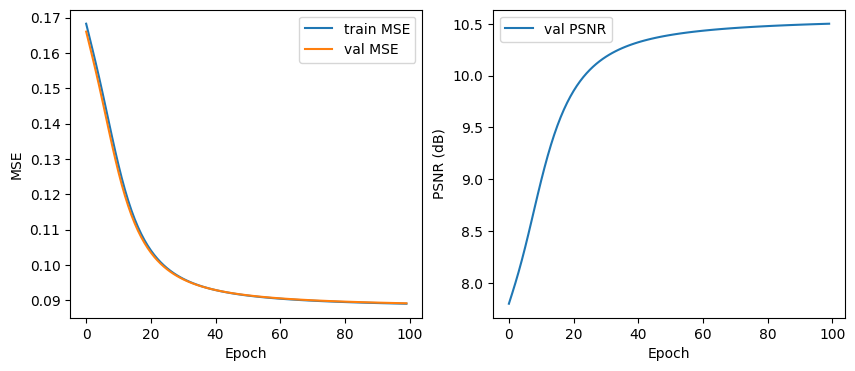

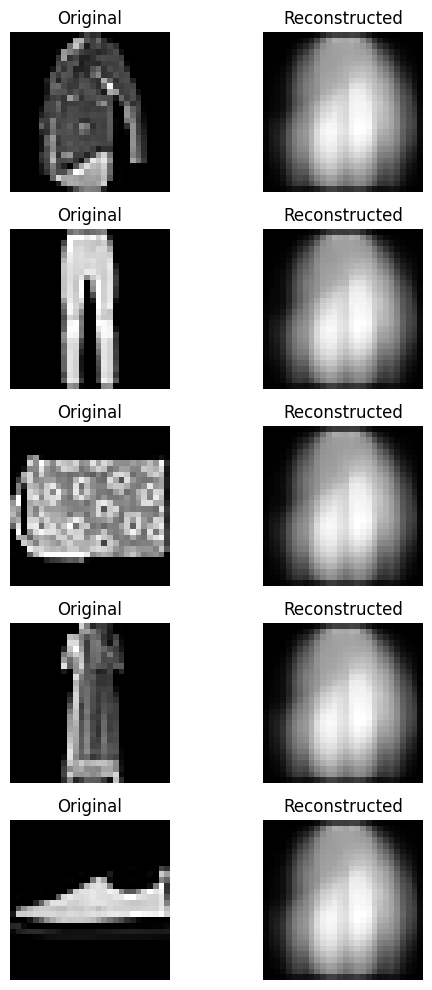

Final Test MSE: 0.08859314303449654 Test PSNR (dB): 10.525998905003277


In [4]:
# Execute Autoencoder
(W1_ae, b1_ae, W2_ae, b2_ae), history = run_example(X_train, X_test, hidden_dim=64, epochs=100, lr=0.01, batch_size=64)